In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

In [2]:
def weight_variable(shape):
    #initial = tf.truncated_normal(shape, stddev=0.1)
    initial = tf.random_normal(shape, stddev=0.1)
    #return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())
    return tf.Variable(initial)

In [3]:
def bias_variable(shape):
    initial = tf.random_normal(shape=shape, stddev=0.1)
    return tf.Variable(initial)

In [4]:
def conv2d(inputs, filters, kernel_size=[3,3], strides=[1,1], activation='Relu', padding='SAME'):
    w_shape = kernel_size + [int(inputs.get_shape()[3])] + [filters]    
    w = weight_variable(w_shape)    
    strides = [1] + strides + [1]
    layer = tf.nn.conv2d(inputs, w, strides=strides, padding=padding)
    if activation == 'Relu':        
        layer = tf.nn.relu(layer)
    elif activation == 'Sigmoid':
        layer = tf.nn.sigmoid(layer)
    else:
        layer = layer    
    return layer

In [5]:
def maxpool2d(inputs, pool_size=[2,2], strides=[2,2], padding='SAME'):
    ksize = [1] + pool_size + [1]
    strides = [1] + strides + [1]
    return tf.nn.max_pool(inputs, ksize=ksize, strides=strides, padding=padding)

In [6]:
def flatten(inputs):
    in_shape = inputs.get_shape()
    return tf.reshape(inputs, [-1, int(in_shape[1]) * int(in_shape[2]) * int(in_shape[3])])

In [7]:
def dense(inputs, units, activation='None'):
    w_shape = [int(inputs.get_shape()[1]), units]    
    w = weight_variable(w_shape)
    b = bias_variable([units])
    layer = tf.nn.bias_add(tf.matmul(inputs, w), b)
    if activation == 'Relu':        
        layer = tf.nn.relu(layer)
    elif activation == 'Sigmoid':
        layer = tf.nn.sigmoid(layer)
    else:
        layer = layer    
    return layer

In [8]:
def dropout(inputs, rate=0.5, training=False):
    keep_prob = 1. - rate
    layer = tf.cond(training, lambda: tf.nn.dropout(inputs, keep_prob=keep_prob), lambda: inputs)
    return layer

In [9]:
mnist = input_data.read_data_sets("../data/", one_hot=True)

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


In [10]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [11]:
is_train = tf.placeholder(tf.bool)
keep_prob = tf.placeholder(tf.float32)

In [12]:
# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

In [13]:
conv1 = conv2d(X_img, 32)
pool1 = maxpool2d(conv1)
drop1 = dropout(pool1, rate=0.3, training=is_train)
#drop1 = tf.nn.dropout(pool1, keep_prob=keep_prob)

In [14]:
conv2 = conv2d(drop1, 64)
pool2 = maxpool2d(conv2)
drop2 = dropout(pool2, rate=0.3, training=is_train)
#drop2 = tf.nn.dropout(pool2, keep_prob=keep_prob)

In [15]:
conv3 = conv2d(drop2, 128)
pool3 = maxpool2d(conv3)
drop3 = dropout(pool3, rate=0.3, training=is_train)
#drop3 = tf.nn.dropout(pool3, keep_prob=keep_prob)

In [16]:
flat3 = flatten(drop3)
dense4 = dense(flat3, 625, activation='Relu')
drop4 = dropout(dense4, rate=0.5, training=is_train)

In [17]:
logits = dense(drop4, 10)

In [18]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [19]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [20]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, is_train: True}
        #feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 0001 cost = 0.733945309
Epoch: 0002 cost = 0.171566382
Epoch: 0003 cost = 0.122186193
Epoch: 0004 cost = 0.094814239
Epoch: 0005 cost = 0.080116983
Epoch: 0006 cost = 0.069865442
Epoch: 0007 cost = 0.062134881
Epoch: 0008 cost = 0.057660156
Epoch: 0009 cost = 0.053155154
Epoch: 0010 cost = 0.048733571
Epoch: 0011 cost = 0.045139475
Epoch: 0012 cost = 0.042168387
Epoch: 0013 cost = 0.041988781
Epoch: 0014 cost = 0.036946269
Epoch: 0015 cost = 0.035003793
Learning Finished!


In [21]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels, is_train: False}))
      #X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1.}))

# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1], is_train: False}))
    #tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 1.}))

Accuracy: 0.9949
Label:  [2]
Prediction:  [2]


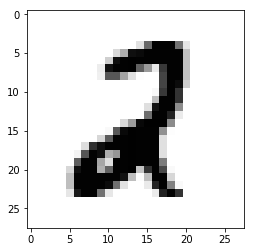

In [22]:
plt.imshow(mnist.test.images[r:r + 1].
          reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()